In [1]:
import pandas as pd
import numpy as np
import glob
import pytz
import os
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
from imblearn.over_sampling import SMOTE, ADASYN
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report, confusion_matrix
import xgboost
from sklearn.model_selection import GridSearchCV

In [35]:
EVENTS_FOLDER = '../data/bishkek_csr/03_train_ready/event_exports' 
RESPECK_FOLDER = '../data/bishkek_csr/03_train_ready/respeck'
NASAL_FOLDER = '../data/bishkek_csr/03_train_ready/nasal_files'
FEATURES_FOLDER = '../data/bishkek_csr/03_train_ready/respeck_features'
# --- Define relevant events ---

APNEA_EVENT_LABELS = [
    'Obstructive Apnea', 
]

# ==============================================================================
# 1. FEATURE GENERATION FUNCTIONS (from our previous conversation)
# ==============================================================================

def generate_RRV(sliced_signal):
    sliced_signal = sliced_signal.dropna()
    if sliced_signal.empty:
        return np.nan
    breathingSignal = sliced_signal.values
    N = len(breathingSignal)
    if N < 2: return 0.0
    yf = np.fft.fft(breathingSignal)
    yff = 2.0 / N * np.abs(yf[:N//2])
    if len(yff) < 2: return 0.0
    dc_component_value = np.amax(yff)
    dc_component_index = np.argmax(yff)
    if dc_component_value == 0: return 0.0 # Avoid division by zero
    temp_dc_removed = np.delete(yff, dc_component_index)
    h1_value = np.amax(temp_dc_removed)
    rrv = 100 - (h1_value / dc_component_value) * 100
    return rrv

def extract_respeck_features(df):
    """
    Processes raw Respeck DataFrame to extract features over 30-second windows.
    Requires the DataFrame to have a DatetimeIndex.
    """
    resampled_df = pd.DataFrame()
    
    # --- Breathing Rate (BR) Features ---
    br_resampler = df["breathingRate"].resample('30s')
    resampled_df["BR_median"] = br_resampler.median()
    resampled_df["BR_mean"] = br_resampler.mean()
    resampled_df["BR_std"] = br_resampler.std()
    resampled_df["BR_cov"] = resampled_df["BR_std"] / resampled_df["BR_mean"]

    # --- Activity Level (AL) Features ---
    al_resampler = df["activityLevel"].resample('30s')
    resampled_df["AL_median"] = al_resampler.median()
    resampled_df["AL_mean"] = al_resampler.mean()
    resampled_df["AL_std"] = al_resampler.std()
    resampled_df["AL_cov"] = resampled_df["AL_std"] / resampled_df["AL_mean"]
        
    # --- Respiratory Rate Variability (RRV) Features ---
    resampled_df["RRV"] = df["breathingSignal"].resample('30s').apply(generate_RRV)
    resampled_df["RRV"] = resampled_df["RRV"].replace(0, np.nan).ffill().bfill()
    resampled_df["RRV3ANN"] = resampled_df["RRV"].rolling(window=3, center=True).mean()
    resampled_df["RRV3ANN"] = resampled_df["RRV3ANN"] * 0.65
    
    return resampled_df
    
    
# ==============================================================================
# 2. MAIN DATA PREPARATION SCRIPT
# ==============================================================================

all_sessions_df_list = []
event_files = glob.glob(os.path.join(EVENTS_FOLDER, '*_event_export.csv'))

if not event_files:
    raise FileNotFoundError(f"No event files found in '{EVENTS_FOLDER}'.")

print(f"Found {len(event_files)} event files. Processing each one...")

for event_file_path in event_files:
    # --- 2a. Setup paths and IDs ---
    base_name = os.path.basename(event_file_path)
    session_id = base_name.split('_event_export.csv')[0]
    respeck_file_path = os.path.join(RESPECK_FOLDER, f'{session_id}_respeck.csv')
    nasal_file_path = os.path.join(NASAL_FOLDER, f'{session_id}_nasal.csv')
    
    if not all(os.path.exists(p) for p in [respeck_file_path, nasal_file_path]):
        print(f"  - WARNING: Skipping session '{session_id}'. A corresponding file is missing.")
        continue
    print(f"  - Processing session: {session_id}")
    
    # --- 2b. Load all data sources ---
    df_events = pd.read_csv(event_file_path, decimal=',')
    df_nasal = pd.read_csv(nasal_file_path)
    df_respeck = pd.read_csv(respeck_file_path)

    # --- 2c. Standardize timestamp columns to Unix milliseconds (integer) ---
    df_events.rename(columns={'UnixTimestamp': 'timestamp_unix'}, inplace=True)
    df_nasal.rename(columns={'UnixTimestamp': 'timestamp_unix'}, inplace=True, errors='ignore')
    df_respeck.rename(columns={'alignedTimestamp': 'timestamp_unix'}, inplace=True)
    df_respeck['timestamp_unix'] = df_respeck['timestamp_unix'].astype(int)
    print(df_respeck['timestamp_unix'])

    df_features['timestamp_unix'] = pd.to_datetime(df_features['startTimestamp'], format="mixed")
    df_features['timestamp_unix'] = df_features['timestamp_unix'].astype('int64') // 10**6
    
    df_features['timestamp_unix_end'] = pd.to_datetime(df_features['endTimestamp'], format="mixed")
    df_features['timestamp_unix_end'] = df_features['timestamp_unix_end'].astype('int64') // 10**6
    
    # --- 4. Calculate the true overlapping time range ---
    start_time = max(df_nasal['timestamp_unix'].min(), df_respeck['timestamp_unix'].min())
    end_time = min(df_nasal['timestamp_unix'].max(), df_respeck['timestamp_unix'].max())
    df_respeck = df_respeck[(df_respeck['timestamp_unix'] >= start_time) & (df_respeck['timestamp_unix'] <= end_time)].copy()

    if df_respeck.empty:
        print(f"  - WARNING: Skipping session '{session_id}'. No Respeck data in the overlapping range.")
        continue
    
    time_diffs_ms = df_respeck['timestamp_unix'].diff().median()
    # **FIXED THE BUG HERE**
    if not pd.isna(time_diffs_ms) and time_diffs_ms > 0:
        fs = 1000.0 / time_diffs_ms
        lowcut, highcut, order = 0.1, 0.8, 2
        nyquist = 0.5 * fs
        b, a = butter(order, [lowcut/nyquist, highcut/nyquist], btype='band')
        # Apply filter to a *new* column to preserve the original
        df_respeck['breathingSignal_filtered'] = filtfilt(b, a, df_respeck['breathingSignal'])
    else:
        print(f"    - WARNING: Invalid sampling rate for {session_id}. Using unfiltered signal.")
        df_respeck['breathingSignal_filtered'] = df_respeck['breathingSignal']
    


    print(len(df_features), len(df_respeck))
    
    # Use merge_asof to find the correct feature window for each respeck data point
    df_session_merged = pd.merge_asof(
        df_respeck,
        df_features,
        on='timestamp_unix',
        direction='backward' # Finds the last feature window that started <= the respeck timestamp
    )

    cols_to_drop = ['Unnamed: 0','startTimestamp', 'endTimestamp', 'timestamp_unix_end']
    df_session_merged.drop(columns=cols_to_drop, inplace=True, errors='ignore')

    if df_session_merged.empty:
        print(f"  - WARNING: Skipping session '{session_id}'. No merge matches found.")
        continue

    # --- 2f. **NEW & IMPROVED:** Label the feature windows directly ---
    print("  - Applying labels to 30-second feature windows...")
    
    # Initialize Label column with 0 (Normal)
    features_df['Label'] = 0
    
    # Calculate event end times
    df_events['Duration_ms'] = (df_events['Duration'] * 1000).astype('int64')
    df_events['end_time_unix'] = df_events['timestamp_unix'] + df_events['Duration_ms']
    df_apnea_events = df_events[df_events['Event'].isin(APNEA_EVENT_LABELS)]

    # Get timestamps for our feature windows
    window_starts = features_df.index.astype('int64') // 10**6
    window_ends = window_starts + 30000 # 30-second windows in milliseconds
    
    # Iterate through apnea events and label any overlapping feature window
    for _, event in df_apnea_events.iterrows():
        event_start = event['timestamp_unix']
        event_end = event['end_time_unix']
        
        # An event overlaps a window if the event starts before the window ends
        # AND the event ends after the window starts.
        overlapping_mask = (event_start < window_ends) & (event_end > window_starts)
        
        features_df.loc[overlapping_mask, 'Label'] = 1

    # --- 2g. Finalize session data ---
    features_df['SessionID'] = session_id
    all_sessions_df_list.append(features_df)

# --- Combine all sessions into a single DataFrame ---
if not all_sessions_df_list:
    raise ValueError("Processing failed. No data was successfully processed.")

final_df = pd.concat(all_sessions_df_list)
final_df.reset_index(inplace=True) # Move timestamp from index to column
final_df.rename(columns={'index': 'timestamp'}, inplace=True)

# --- Display Final Results ---
print("\n----------------------------------------------------")
print("Data loading with INTEGRATED feature generation and labeling complete.")
print(f"Final DataFrame shape: {final_df.shape}")
print(f"Data granularity: 1 row per 30-second window.")
print(f"Final class distribution: \n{final_df['Label'].value_counts(normalize=True)}")
print("\nFinal DataFrame head:")

Found 9 event files. Processing each one...
  - Processing session: 26-04-2025
0         1745604054037
1         1745604054117
2         1745604054197
3         1745604054277
4         1745604054357
              ...      
432379    1745640814222
432380    1745640814302
432381    1745640814382
432382    1745640814462
432383    1745640814542
Name: timestamp_unix, Length: 432384, dtype: int64
  - Preparing and merging engineered features using Unix time intervals...
3306 198161
  - Applying precise interval-based labels...
  - Processing session: 08-05-2025
0         1746640858562
1         1746640858642
2         1746640858722
3         1746640858802
4         1746640858882
              ...      
263419    1746661908255
263420    1746661908335
263421    1746661908415
263422    1746661908495
263423    1746661908575
Name: timestamp_unix, Length: 263424, dtype: int64
  - Preparing and merging engineered features using Unix time intervals...
3248 252278
  - Applying precise interval-based 

In [58]:
# Windowing: Creating the time-series segments.
print(df.columns)

SAMPLING_RATE_HZ = 12.5
WINDOW_DURATION_SEC = 30
WINDOW_SIZE = int(WINDOW_DURATION_SEC * SAMPLING_RATE_HZ)

# Step size for sliding window. An 80% overlap is a good start.
OVERLAP_PERCENTAGE = 0.80
STEP_SIZE = int(WINDOW_SIZE * (1 - OVERLAP_PERCENTAGE))

# === Data Parameters ===
FEATURE_COLUMNS = [
    'breathingSignal', 
    'activityLevel',
    'peakRespiratoryFlow', 
    'breath_regularity',
    'BR_mean'
]
LABEL_COLUMN = 'Label' 
SESSION_ID_COLUMN = 'SessionID'

TEST_NIGHTS = 2
TOTAL_NIGHTS = 9 
TEST_SIZE = TEST_NIGHTS / TOTAL_NIGHTS

RANDOM_STATE = 42
EPOCHS = 100
BATCH_SIZE = 64

X = df[FEATURE_COLUMNS].values
y = df[LABEL_COLUMN].values
groups = df[SESSION_ID_COLUMN].values

# --- 3. Impute any remaining NaNs ---
# It's better to do this after splitting into X and y.
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

print("Data preparation complete.")
print(f"Shape of X (features): {X.shape} -> (Num_Windows, Num_Engineered_Features)")
print(f"Shape of y (labels):   {y.shape}")

Index(['timestamp_unix', 'timestamp', 'interpolatedPhoneTimestamp',
       'respeckTimestamp', 'sequenceNumber', 'x', 'y', 'z', 'breathingSignal',
       'breathingRate', 'activityLevel', 'activityType', 'type', 'area',
       'extremas', 'meanActivityLevel', 'modeActivityType',
       'peakRespiratoryFlow', 'duration', 'BR_md', 'BR_mean', 'BR_std',
       'AL_md', 'AL_mean', 'AL_std', 'RRV', 'RRV3MA', 'breath_regularity',
       'Label', 'SessionID'],
      dtype='object')


In [59]:
print("\nChecking for and imputing missing values (NaNs)...")
for col in df:
    if col in df.columns:
        nan_count = df[col].isnull().sum()
        if nan_count > 0:
            print(f"  - Found {nan_count} NaNs in '{col}'. Applying forward-fill and backward-fill.")
            
            # Step 1: Forward-fill handles all NaNs except leading ones.
            df[col].ffill(inplace=True) 
            
            # Step 2: Backward-fill handles any remaining NaNs at the beginning of the file.
            df[col].bfill(inplace=True) 

# Add a final check to ensure everything is clean
final_nan_count = df[FEATURE_COLUMNS].isnull().sum().sum()
if final_nan_count > 0:
    print(f"\nWARNING: {final_nan_count} NaNs still remain in feature columns after imputation. Please investigate.")
else:
    print("\nImputation complete. No NaNs remain in feature columns.")


Checking for and imputing missing values (NaNs)...
  - Found 4630 NaNs in 'breathingSignal'. Applying forward-fill and backward-fill.
  - Found 2097749 NaNs in 'breathingRate'. Applying forward-fill and backward-fill.
  - Found 2110 NaNs in 'type'. Applying forward-fill and backward-fill.


/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_1454/370400962.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].ffill(inplace=True)
/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_1454/370400962.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

  - Found 2110 NaNs in 'area'. Applying forward-fill and backward-fill.
  - Found 2110 NaNs in 'extremas'. Applying forward-fill and backward-fill.
  - Found 2110 NaNs in 'meanActivityLevel'. Applying forward-fill and backward-fill.
  - Found 2110 NaNs in 'modeActivityType'. Applying forward-fill and backward-fill.
  - Found 2110 NaNs in 'peakRespiratoryFlow'. Applying forward-fill and backward-fill.
  - Found 2110 NaNs in 'duration'. Applying forward-fill and backward-fill.
  - Found 2110 NaNs in 'BR_md'. Applying forward-fill and backward-fill.
  - Found 2110 NaNs in 'BR_mean'. Applying forward-fill and backward-fill.
  - Found 2110 NaNs in 'BR_std'. Applying forward-fill and backward-fill.
  - Found 2110 NaNs in 'AL_md'. Applying forward-fill and backward-fill.
  - Found 2110 NaNs in 'AL_mean'. Applying forward-fill and backward-fill.
  - Found 2110 NaNs in 'AL_std'. Applying forward-fill and backward-fill.
  - Found 2110 NaNs in 'RRV'. Applying forward-fill and backward-fill.
  - F

In [60]:
X = []
y = []
groups = [] 

print("Starting the windowing process...")

# --- 3. Loop through each session (night) to create windows ---
# We group by SessionID to ensure windows do not cross over between nights.
for session_id, session_df in df.groupby(SESSION_ID_COLUMN):
    for i in range(0, len(session_df) - WINDOW_SIZE, STEP_SIZE):
        
        window_df = session_df.iloc[i : i + WINDOW_SIZE]
        
        features = window_df[FEATURE_COLUMNS].values
        
        # --- CORRECTED LABELING LOGIC ---
        # The 'Label' column already contains 0s and 1s.
        # If the sum of labels in the window is > 0, it means there's at least one '1' (Apnea).
        if window_df[LABEL_COLUMN].sum() > 0:
            label = 1 # Apnea
        else:
            label = 0 # Normal
        # ------------------------------------
            
        X.append(features)
        y.append(label)
        groups.append(session_id)

# --- 4. Convert the lists into efficient NumPy arrays ---
X = np.asarray(X)
y = np.asarray(y)
groups = np.asarray(groups)

# --- 5. Print a summary of the results ---
print("\nData windowing complete.")
print("----------------------------------------------------")
print(f"Shape of X (features): {X.shape} -> (Num_Windows, Window_Size, Num_Features)")
print(f"Shape of y (labels):   {y.shape}")
print(f"Shape of groups (IDs): {groups.shape}")
print(f"Final class distribution across all windows: {Counter(y)} (0=Normal, 1=Apnea)")

Starting the windowing process...

Data windowing complete.
----------------------------------------------------
Shape of X (features): (28868, 375, 5) -> (Num_Windows, Window_Size, Num_Features)
Shape of y (labels):   (28868,)
Shape of groups (IDs): (28868,)
Final class distribution across all windows: Counter({np.int64(0): 27958, np.int64(1): 910}) (0=Normal, 1=Apnea)


In [61]:
# Splitting dataset

unique_session_ids = np.unique(groups)
print(unique_session_ids)
n_total_sessions = len(unique_session_ids)

print(f"Found {n_total_sessions} unique sessions (nights) in the dataset: {unique_session_ids}")

train_ids, test_ids = train_test_split(
    unique_session_ids, 
    test_size=TEST_NIGHTS, 
    # random_state=RANDOM_STATE
)
print(f"\nSplitting data into training and testing sets...")
print(f"  - Sessions assigned to TRAINING set: {train_ids}")
print(f"  - Sessions assigned to TESTING set:  {test_ids}")

train_mask = np.isin(groups, train_ids)
test_mask = np.isin(groups, test_ids)

# --- 4. Apply the masks to create the final data sets ---
X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

# --- 5. Verify the results ---
print("\nTrain-test split complete.")
print("----------------------------------------------------")
print(f"Total windows in training set:   {len(X_train)}")
print(f"Total windows in testing set:    {len(X_test)}")
print(f"Shape of X_train:                {X_train.shape}")
print(f"Shape of X_test:                 {X_test.shape}")
print(f"Training set class distribution: {Counter(y_train)} (0=Normal, 1=Apnea)")
print(f"Testing set class distribution:  {Counter(y_test)} (0=Normal, 1=Apnea)")

Found 8 unique sessions (nights) in the dataset: ['04-04-2025' '05-04-2025' '08-05-2025' '10-05-2025' '11-05-2025'
 '16-04-2025' '24-04-2025' '26-04-2025']

Splitting data into training and testing sets...
  - Sessions assigned to TRAINING set: ['16-04-2025' '04-04-2025' '26-04-2025' '08-05-2025' '11-05-2025'
 '10-05-2025' '24-04-2025']
  - Sessions assigned to TESTING set:  ['25-04-2025' '05-04-2025']

Train-test split complete.
----------------------------------------------------
Total windows in training set:   21374
Total windows in testing set:    7494
Shape of X_train:                (21374, 375, 5)
Shape of X_test:                 (7494, 375, 5)
Training set class distribution: Counter({np.int64(0): 20839, np.int64(1): 535}) (0=Normal, 1=Apnea)
Testing set class distribution:  Counter({np.int64(0): 7119, np.int64(1): 375}) (0=Normal, 1=Apnea)


In [62]:
# nsamples, n_timesteps, n_features = X_train.shape
# X_train_reshaped = X_train.reshape((nsamples, n_timesteps * n_features))

# print("Balancing the training data using SMOTE...")
# print(f"  - Original training distribution: {Counter(y_train)}")

# # --- 2. Initialize and apply SMOTE ---
# # `random_state` ensures that the synthetic samples are the same each time you run the code.
# smote = SMOTE(random_state=RANDOM_STATE)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, y_train)

# print(f"  - Resampled training distribution: {Counter(y_train_resampled)}")

# # --- 3. Reshape the balanced training data back to its original 3D format ---
# # The model expects the data in the format (samples, timesteps, features).
# X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], n_timesteps, n_features))

# X_train_tensor = torch.from_numpy(X_train_resampled).float()
# y_train_tensor = torch.from_numpy(y_train_resampled).long() # Use .long() for class indices

# X_test_tensor = torch.from_numpy(X_test).float()
# y_test_tensor = torch.from_numpy(y_test).long()

# # Create TensorDatasets
# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# # Create DataLoaders to handle batching and shuffling
# # BATCH_SIZE is from your configuration cell
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# print("\nPyTorch DataLoaders created successfully.")


In [63]:
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else ("mps" if torch.backends.mps.is_available() else "cpu")
)
print(f"Using device: {device}")

Using device: mps


Starting XGBoost Leave-One-Night-Out cross-validation with 8 folds...
----------------------------------------------------\n
--- FOLD 1/8 ---
Testing on Night: 04-04-2025\n
  - Data flattened for XGBoost. Train shape: (25317, 1875)
  - Original training distribution: Counter({np.int64(0): 24608, np.int64(1): 709})
  - Resampled training distribution: Counter({np.int64(0): 24608, np.int64(1): 24608})
  - Training XGBoost model...
  - Training complete.
  - Evaluation complete for fold 1.\n
--- FOLD 2/8 ---
Testing on Night: 05-04-2025\n
  - Data flattened for XGBoost. Train shape: (25604, 1875)
  - Original training distribution: Counter({np.int64(0): 24997, np.int64(1): 607})
  - Resampled training distribution: Counter({np.int64(0): 24997, np.int64(1): 24997})
  - Training XGBoost model...
  - Training complete.
  - Evaluation complete for fold 2.\n
--- FOLD 3/8 ---
Testing on Night: 08-05-2025\n
  - Data flattened for XGBoost. Train shape: (25463, 1875)
  - Original training distribu

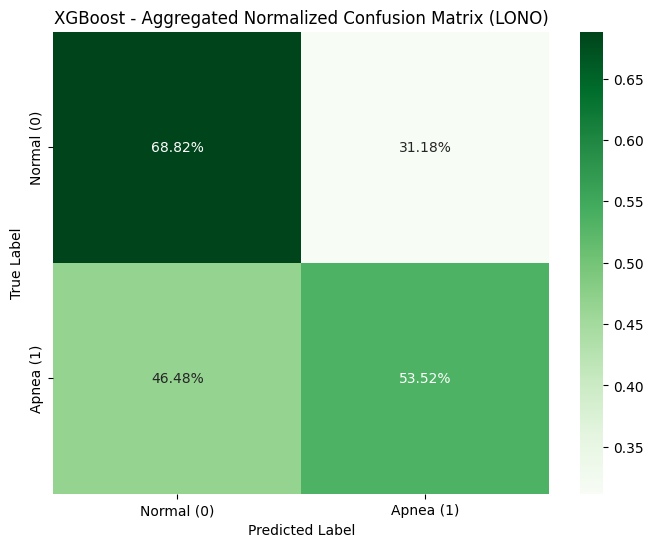

In [64]:

import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# --- 2. Initialize lists to store results from all folds ---\n",
all_fold_predictions = []
all_fold_true_labels = []
all_fold_importances = [] # <-- NEW: List to store importance dataframes

# --- 3. Setup Leave-One-Night-Out cross-validator ---\n",
logo = LeaveOneGroupOut()
n_folds = logo.get_n_splits(groups=groups)
print(f"Starting XGBoost Leave-One-Night-Out cross-validation with {n_folds} folds...")
print("----------------------------------------------------\\n")

# --- 4. Loop through each fold ---\n",
for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    
    test_night = np.unique(groups[test_idx])[0]
    print(f"--- FOLD {fold + 1}/{n_folds} ---")
    print(f"Testing on Night: {test_night}\\n")

    # --- Split the data for this fold ---\n",
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # --- 5. FLATTEN THE DATA for XGBoost ---
    # Convert the 3D windowed data (samples, timesteps, features) to 2D
    n_timesteps, n_features = X_train.shape[1], X_train.shape[2]
    X_train_flattened = X_train.reshape(-1, n_timesteps * n_features)
    X_test_flattened = X_test.reshape(-1, n_timesteps * n_features)
    print(f"  - Data flattened for XGBoost. Train shape: {X_train_flattened.shape}")
    
    # --- Balance the TRAINING data for this fold using SMOTE ---\n",
    print(f"  - Original training distribution: {Counter(y_train)}")
    smote = SMOTE(random_state=RANDOM_STATE)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    print(f"  - Resampled training distribution: {Counter(y_train_resampled)}")

    # # pos_weight = Counter(y_train)[0] / Counter(y_train)[1]
    # print(f"  - Calculated scale_pos_weight: {pos_weight:.2f}")

    # --- 7. Initialize and Train a NEW XGBoost model for this fold ---
    print("  - Training XGBoost model...")
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        # scale_pos_weight=pos_weight,
        n_estimators=300,         # Number of trees (can be tuned)
        learning_rate=0.001,
        max_depth=5,              # Max depth of a tree (can be tuned)
        eval_metric='logloss',
        random_state=RANDOM_STATE,
        n_jobs=-1                 # Use all available CPU cores for faster training
    )
    
    # Train the model on the balanced data
    model.fit(X_train_resampled, y_train_resampled)
    print(f"  - Training complete.")
            
    # --- 8. Evaluate the fold and store results ---
    fold_preds = model.predict(X_test_flattened)
    
    all_fold_predictions.extend(fold_preds)
    all_fold_true_labels.extend(y_test)

    # --- NEW: Capture and store feature importances for this fold ---
    fold_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    })
    all_fold_importances.append(fold_importance_df)
    # --- END OF NEW PART ---

    print(f"  - Evaluation complete for fold {fold + 1}.\\n")

print("  - Calculating permutation importance...")
# Use the test set for this fold
result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1, scoring='f1'
)

# Store results, and after all folds, average them and plot
perm_importance = pd.DataFrame({
    'Feature': FEATURE_COLUMNS,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)
        

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=perm_importance)
plt.title(f'Feature Importance for Fold {fold + 1}')
plt.show()
print("  - Calculating SHAP values...")
# Create an explainer object
explainer = shap.TreeExplainer(model)
# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Plot a summary of feature importance and impact
shap.summary_plot(shap_values, X_test, feature_names=FEATURE_COLUMNS)



# --- FINAL AGGREGATED EVALUATION (after all folds are complete) ---\n",
print("\\n====================================================")
print("XGBoost Leave-One-Night-Out Cross-Validation Complete.")
print("Aggregated Results Across All Folds:")
print("====================================================")

# --- Final Classification Report (no changes here) ---\n",
print('\\nAggregated Classification Report')
print('------------------------------')
class_names = ['Normal (0)', 'Apnea (1)']
print(classification_report(all_fold_true_labels, all_fold_predictions, target_names=class_names))

# --- Final Confusion Matrix (no changes here) ---\n",
print('Aggregated Confusion Matrix')
print('---------------------------')
cm = confusion_matrix(all_fold_true_labels, all_fold_predictions)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm, annot=True, fmt='.2%', cmap='Greens',
    xticklabels=class_names, yticklabels=class_names
)
plt.title('XGBoost - Aggregated Normalized Confusion Matrix (LONO)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

\n====================================================
Feature Importance Analysis (Averaged Across All Folds)


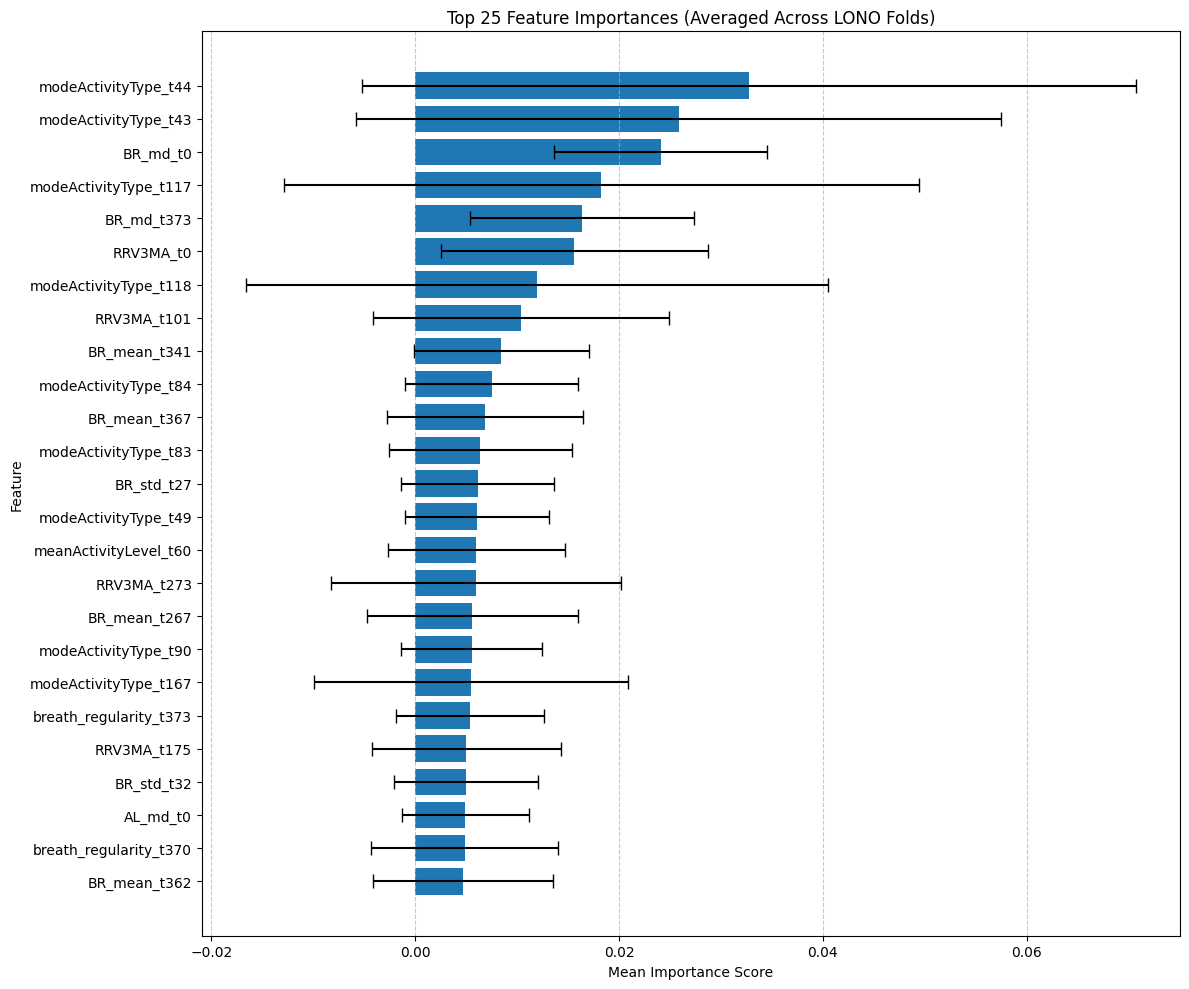

In [9]:
# --- AGGREGATE AND PLOT FEATURE IMPORTANCES ---
print("\\n====================================================")
print("Feature Importance Analysis (Averaged Across All Folds)")
print("====================================================")

# --- 1. Aggregate Data from All Folds ---
all_importances_df = pd.concat(all_fold_importances)
mean_importance = all_importances_df.groupby('feature')['importance'].mean()
std_importance = all_importances_df.groupby('feature')['importance'].std()

# --- 2. Prepare the DataFrame for Plotting ---
final_importance_df = pd.DataFrame({
    'mean_importance': mean_importance,
    'std_importance': std_importance
})
final_importance_df = final_importance_df.sort_values(by='mean_importance', ascending=False)

# --- 3. Create the Plot using Matplotlib Directly ---
# This bypasses the seaborn issue and provides direct control.
top_n = 25
plot_data = final_importance_df.head(top_n)

# Create the figure and axes objects
fig, ax = plt.subplots(figsize=(12, 10))

# Create the horizontal bar plot
ax.barh(
    y=plot_data.index,          # Feature names for the y-axis
    width=plot_data['mean_importance'], # Bar lengths for the x-axis
    xerr=plot_data['std_importance'],   # Error bars
    align='center',
    ecolor='black',             # Color of the error bar lines
    capsize=5                   # Size of the error bar caps
)

# --- Final Touches for a Clean Plot ---
# Invert the y-axis so the most important feature is at the top
ax.invert_yaxis() 
ax.set_xlabel('Mean Importance Score')
ax.set_ylabel('Feature')
ax.set_title(f'Top {top_n} Feature Importances (Averaged Across LONO Folds)')

# Add grid lines for better readability
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Ensure the layout is tight
plt.tight_layout()
plt.show()